<a href="https://colab.research.google.com/github/shenjiejie2017/MNIST-handwritten-digit-recog/blob/main/MNIST_handwritten_digit_semi_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST handwritten digit recognition
Labeled data in real life is precious. In this project, I will try to use 1% of labeled data (600 out of 60,000 data in training set) and use a semi-supervised learning method (self-learning) to iteratively add the rest of the unlabeled training data to boost the accuracy of predicting digits (0 to 9) of 10,000 testing data from 91% to 95%.

In [1]:
#I use Google Collab so I need to import google drive and mount file for data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#import files
import time
import gzip
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold,neighbors
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from skimage.restoration import denoise_tv_chambolle
from skimage import morphology
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle
from skimage.restoration import denoise_bilateral
from skimage.feature import canny

%matplotlib inline

#Special display options
pd.set_option("display.max_columns", None) 

In [3]:
#Function to read idx file
def read_idx(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
#Read data files
raw_train=read_idx("/content/drive/MyDrive/MNIST Data/train-images-idx3-ubyte.gz")
train_label=read_idx("/content/drive/MyDrive/MNIST Data/train-labels-idx1-ubyte.gz")
raw_test=read_idx("/content/drive/MyDrive/MNIST Data/t10k-images-idx3-ubyte.gz")
test_label=read_idx("/content/drive/MyDrive/MNIST Data/t10k-labels-idx1-ubyte.gz")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [5]:
#Take a look at data shape
print(f"training data shape: {raw_train.shape}")
print(f"training label shape: {train_label.shape}")
print(f"testing data shape: {raw_test.shape}")
print(f"testing label shape: {test_label.shape}")

training data shape: (60000, 28, 28)
training label shape: (60000,)
testing data shape: (10000, 28, 28)
testing label shape: (10000,)


In [6]:
#Reshape training and testing data
train_data=np.reshape(raw_train, (60000,28*28))
test_data=np.reshape(raw_test, (10000,28*28))

In [7]:
#Choose labeled data in training data
#Generate index for labeled and unlabeled
arr=np.arange(train_data.shape[0])
np.random.shuffle(arr)
idx_w_label=arr[:600]
idx_no_label=arr[600:]

#training data with label
X_train = train_data/255.0
X_train_w_label=X_train[idx_w_label]
y_train = train_label
y_train_w_label = train_label[idx_w_label]

#training data with no label
X_train_no_label = X_train[idx_no_label]
y_train_no_label = y_train[idx_no_label]

#Prepare testing data 
X_test=test_data/255.0
y_test=test_label

In [8]:
#function to display specific image
def plot_items(X, index, figsize_row_size, figsize_col_size, figure_row_num, figure_col_num):
    fig = plt.figure(figsize=(figsize_row_size,figsize_col_size))
    for i in range(len(index)):
     
      ax = fig.add_subplot(figure_row_num,figure_col_num,i+1)
      ax.grid(False)
      imgplot = ax.imshow(np.reshape(X[index[i],:], (28,28)),cmap=plt.cm.get_cmap("Greys"))
      imgplot.set_interpolation("nearest")
      ax.set(xlabel=None)
      ax.set(ylabel=None)
   
    plt.show()

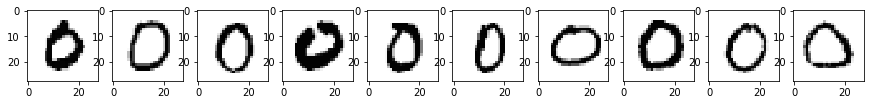

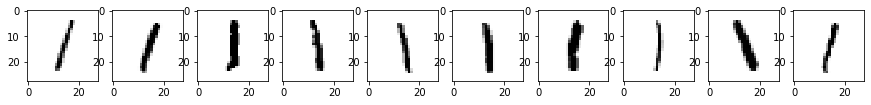

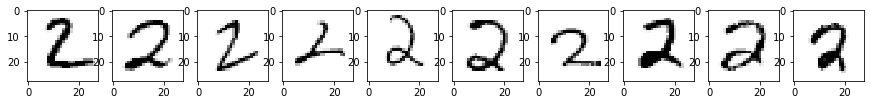

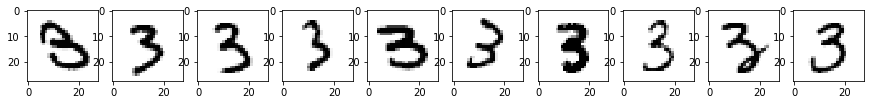

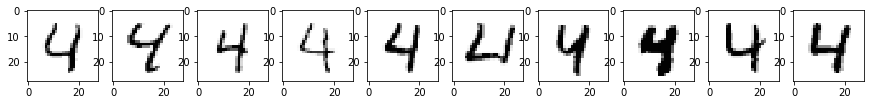

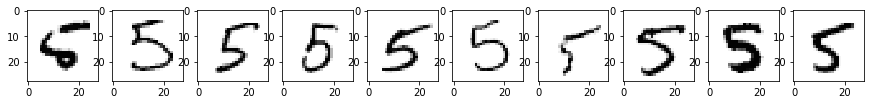

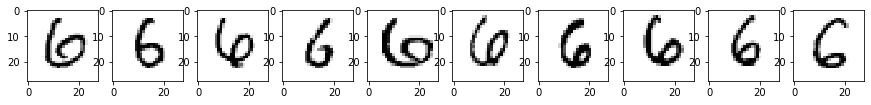

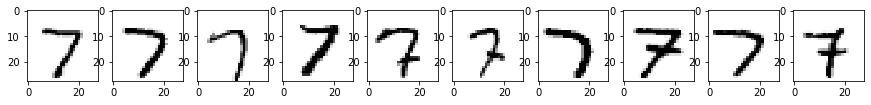

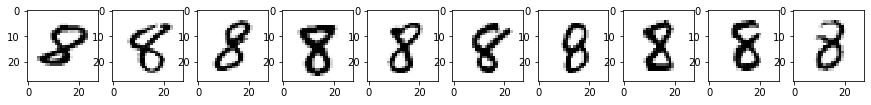

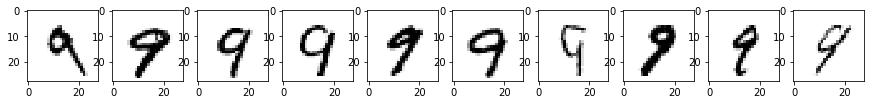

In [9]:
#Take a look at the images in each of 10 categories in testing data
for i in range(10):
   idx=np.where( (y_test==i))[0][:10]
   plot_items(X=X_test, index=idx, figsize_row_size=15, figsize_col_size=5, figure_row_num=1, figure_col_num=len(idx))

#### SVM seem to perform better than KNN. I've tried KNN on this data set and SVM performs better. Since it takes time to run through codes, I'll just focus on SVM to do self-training. 

## SVM training with only labeled data we choose

In [10]:
#Use Grid Search to find best parameter for SVM
start_time=time.time()
param_grid={'C': [2,3,4,5,6,7,8,9],'gamma':[0.01,0.0125,0.015,0.02,0.025,0.03,0.035],'kernel':['rbf']}
svc=SVC(probability=True)
model=GridSearchCV(svc,param_grid, return_train_score=True)
model.fit(X_train_w_label, y_train_w_label)
print("--- %s seconds ---" % (time.time() - start_time))

--- 168.33551359176636 seconds ---


In [11]:
#Take a look to see how model predict testing data using only labeled data we choose
y_pred_only_use_labeled_data =model.predict(X_test)

#Get accuracy score and best parameters
print(f"Accuracy score of using only chosen labeled data: {accuracy_score(y_test ,y_pred_only_use_labeled_data)*100}%")
print(f"best params is: {model.best_params_}")


Accuracy score of using only chosen labeled data: 91.34%
best params is: {'C': 2, 'gamma': 0.025, 'kernel': 'rbf'}


In [12]:
cv_results_df=pd.DataFrame(model.cv_results_)

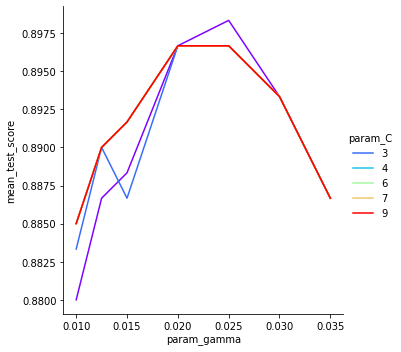

In [13]:
#graph some grid search results
sns.relplot( data=cv_results_df, x= cv_results_df['param_gamma'],y=cv_results_df['mean_test_score'], kind='line', hue=cv_results_df['param_C'],palette='rainbow')


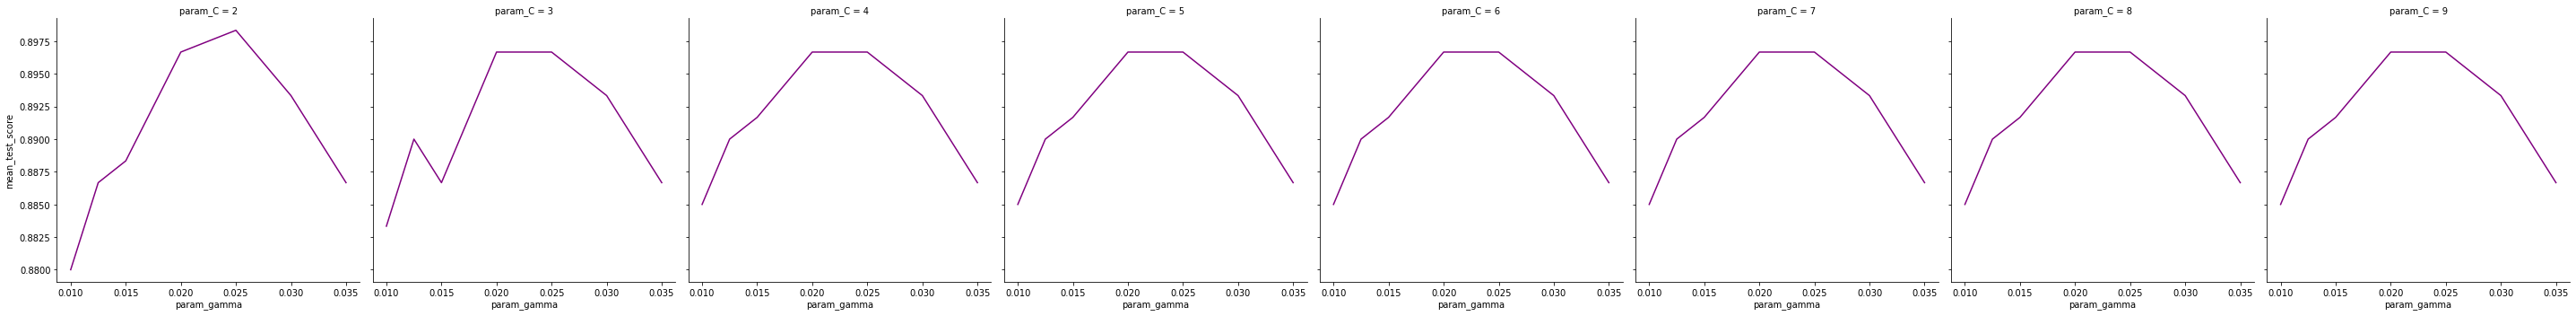

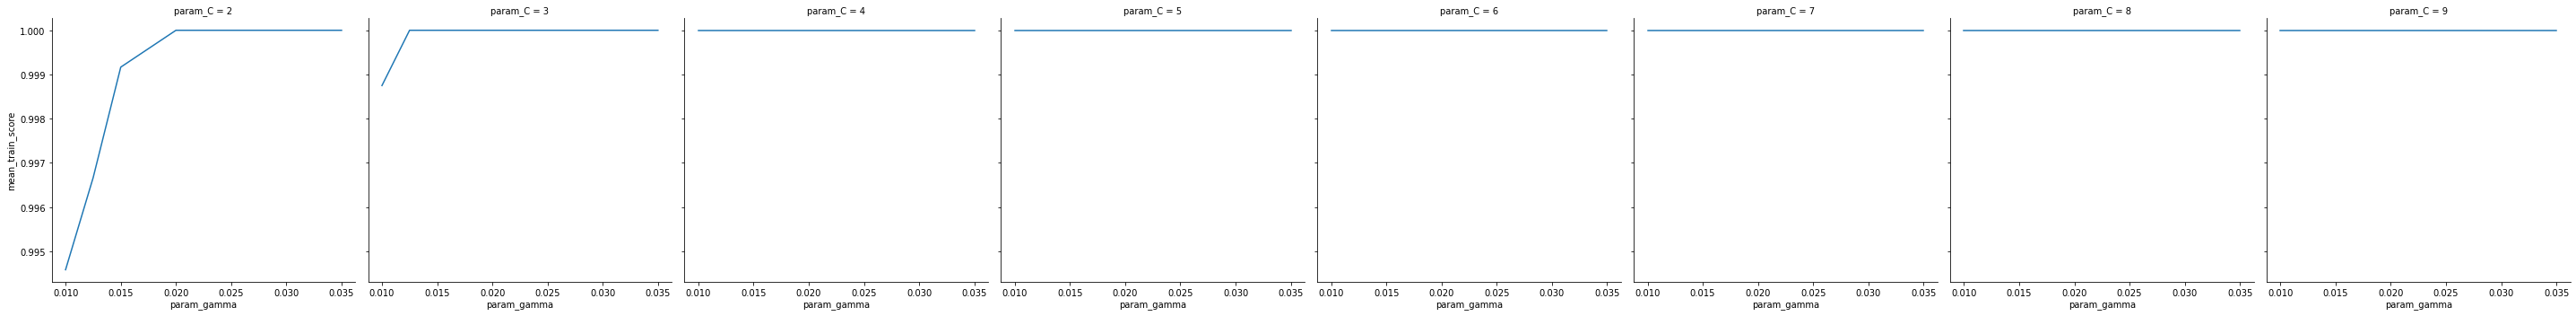

In [14]:
#graph some grid search results

sns.relplot( data=cv_results_df, x= cv_results_df['param_gamma'],y=cv_results_df['mean_test_score'], kind='line', col=cv_results_df['param_C'],  color='purple')
sns.relplot( data=cv_results_df, x= cv_results_df['param_gamma'],y=cv_results_df['mean_train_score'], kind='line', col=cv_results_df['param_C'],  palette='blue')



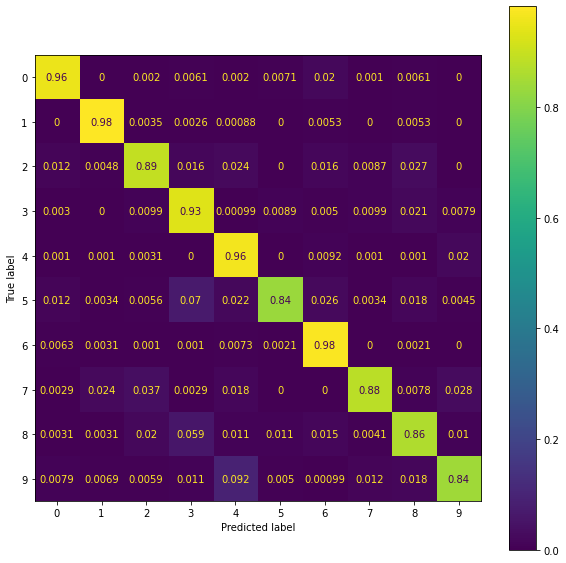

In [15]:
#Plot confusion Matrix
cm_only_use_labeled_data= confusion_matrix(y_test ,y_pred_only_use_labeled_data, normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_only_use_labeled_data, display_labels=model.classes_)
fig, ax=plt.subplots(figsize=(10,10))
disp.plot( ax=ax)

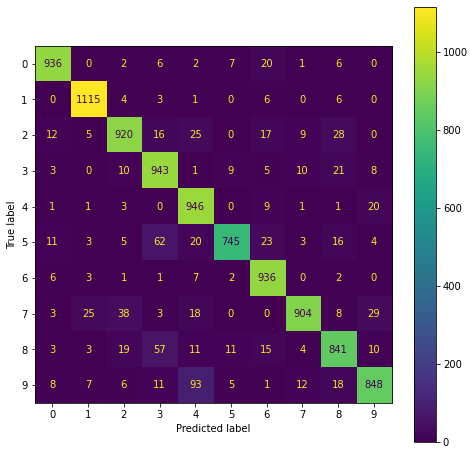

In [16]:
#Plot confusion Matrix
cm_only_use_labeled_data= confusion_matrix(y_test ,y_pred_only_use_labeled_data)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_only_use_labeled_data, display_labels=model.classes_)
fig, ax=plt.subplots(figsize=(8,8))
disp.plot( ax=ax)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counter plot of predicted labels on testing data')

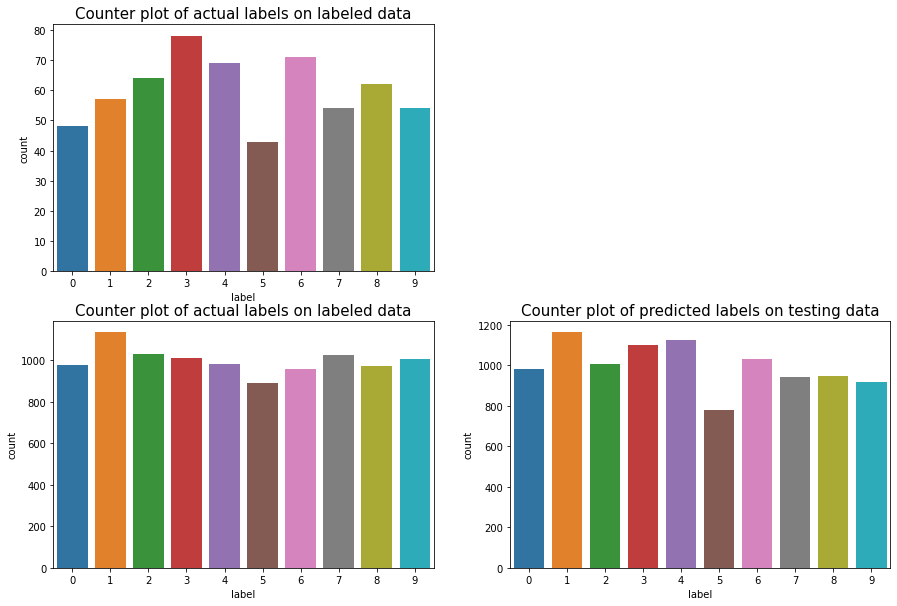

In [17]:
#Draw some counter plot to see label data distributions, the goal is to see distribution of selected labeled data 
#First create some data frame so I can use Seaborn
y_train_w_label_df= pd.DataFrame(y_train_w_label.reshape(600,1),columns=['label'])
y_test_df= pd.DataFrame(y_test.reshape(10000,1),columns=['label'])
y_pred_only_use_labeled_data_df= pd.DataFrame(y_pred_only_use_labeled_data.reshape(y_pred_only_use_labeled_data.shape[0],1),columns=['label'])

#draw counter plots
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.countplot(y_train_w_label_df['label'])
plt.title(f'Counter plot of actual labels on labeled data',size=15)

plt.subplot(2,2,3)
sns.countplot(y_test_df['label'])
plt.title(f'Counter plot of actual labels on labeled data',size=15)

plt.subplot(2,2,4)
sns.countplot(y_pred_only_use_labeled_data_df['label'])
plt.title(f'Counter plot of predicted labels on testing data',size=15)


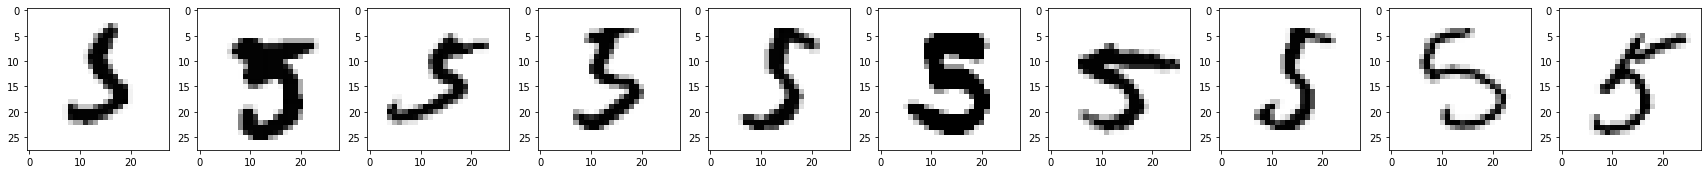

In [18]:
#Display problem numbers
idx_error=np.where((y_pred_only_use_labeled_data==3)& (y_test==5))[0][:10]
plot_items(X=X_test, index=idx_error, figsize_row_size=30, figsize_col_size=10, figure_row_num=1, figure_col_num=len(idx_error))

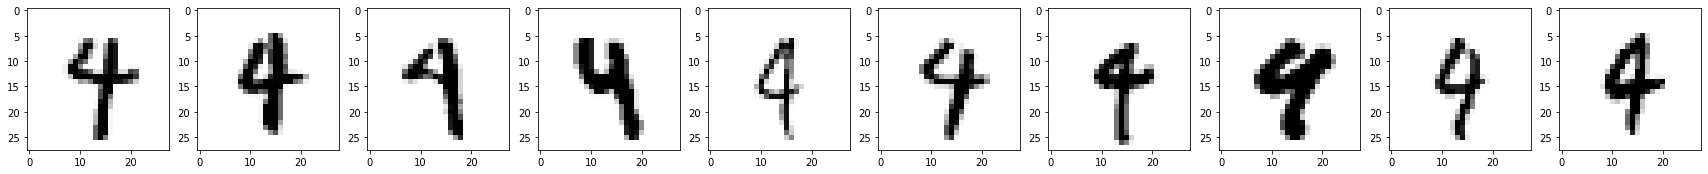

In [19]:
#Display problem numbers
idx_error=np.where((y_pred_only_use_labeled_data==9)& (y_test==4))[0][:10]
plot_items(X=X_test, index=idx_error, figsize_row_size=30, figsize_col_size=10, figure_row_num=1, figure_col_num=len(idx_error))

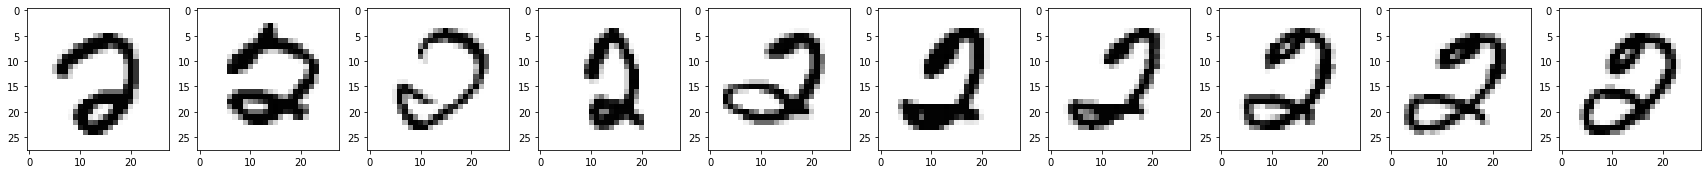

In [20]:
#Display problem numbers
idx_error=np.where((y_pred_only_use_labeled_data==0)& (y_test==2))[0][:10]
plot_items(X=X_test, index=idx_error, figsize_row_size=30, figsize_col_size=10, figure_row_num=1, figure_col_num=len(idx_error))

It seems the model predict some numbers worse than others. Part of reason could be when select labeled data in training set, the selection isn't even. 

### Part 3.1: Dive in predicted labels and find probability threshold for each items

In [21]:
#From Grid Search, choose the best param and train model of choosen labeled data.
#Since I use small subset for gridsearch, best param change a bit depends on what data were chosen for grid search. I just use one of the best ones in predicting test data.
start_time=time.time()
svc=SVC(C=2, gamma=0.025, kernel='rbf', probability=True).fit(X_train_w_label, y_train_w_label)
print("--- %s seconds ---" % (time.time() - start_time))


#Take a look to see how model do on testing data 
#y_pred_only_use_labeled_data =svc.predict(X_test)

y_pred_only_use_labeled_data_prob_full = svc.predict_proba(X_test)
y_pred_only_use_labeled_data_prob = np.max(y_pred_only_use_labeled_data_prob_full , axis=1) 
y_pred_only_use_labeled_data=np.argmax(y_pred_only_use_labeled_data_prob_full, axis=1)  %10

#Get accuracy score and best parameters
print(f"Accuracy score of using only chosen labeled data: {accuracy_score(y_test ,y_pred_only_use_labeled_data)*100}%")

--- 0.7962124347686768 seconds ---
Accuracy score of using only chosen labeled data: 91.60000000000001%


From heatmap, model predict most categories well except a few categories. I think those ones need a different probability threshold. Let's find out what threshold we should use below and train model again.

In [22]:
#Create data frame with probabilities, max probability, and predicated label for easy display
y_pred_only_use_labeled_data_concate= np.concatenate( (y_pred_only_use_labeled_data_prob_full, y_pred_only_use_labeled_data_prob.reshape(y_pred_only_use_labeled_data_prob.shape[0],1),
                                                       y_pred_only_use_labeled_data.reshape(y_pred_only_use_labeled_data.shape[0],1), y_test.reshape(y_test.shape[0],1)), axis=1 )
y_pred_only_use_labeled_data_df = pd.DataFrame(y_pred_only_use_labeled_data_concate,columns=[0,1,2,3,4,5,6,7,8,9,'max_prob','predicted_label','actual_label'])

y_pred_only_use_labeled_data_df= y_pred_only_use_labeled_data_df.sort_values(by="max_prob", ascending=False)

#add indicator column to indicate correct prediction
y_pred_only_use_labeled_data_df['correct_pred'] = y_pred_only_use_labeled_data_df['actual_label'] == y_pred_only_use_labeled_data_df['predicted_label']

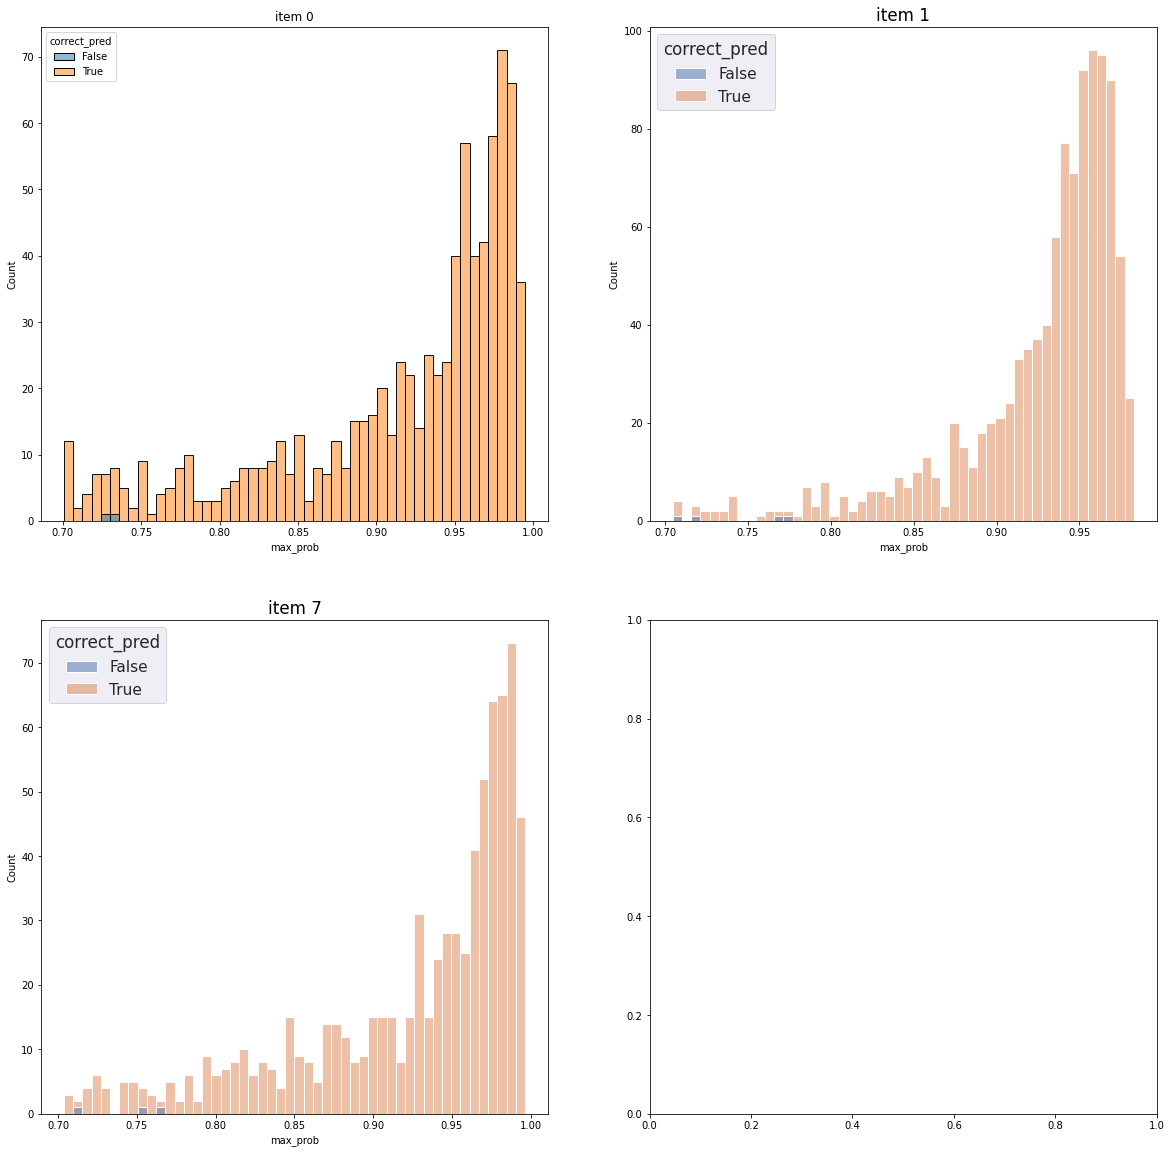

In [23]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
count=0
for i in [0,1,7]:
    df=y_pred_only_use_labeled_data_df[(y_pred_only_use_labeled_data_df['predicted_label']==i) & (y_pred_only_use_labeled_data_df['max_prob']>0.7)& (y_pred_only_use_labeled_data_df['max_prob']<=0.999)]
    sns.histplot(data=df, x='max_prob', hue='correct_pred', ax=axs[(count)//2,(count)%2], bins=50).set(title='item '+str(i))
    sns.set(font_scale=1.4)
    #res.set_xticklabels(np.arange(start=0.090, stop=1.001, decimals=3), fontsize = 10)
    count+=1


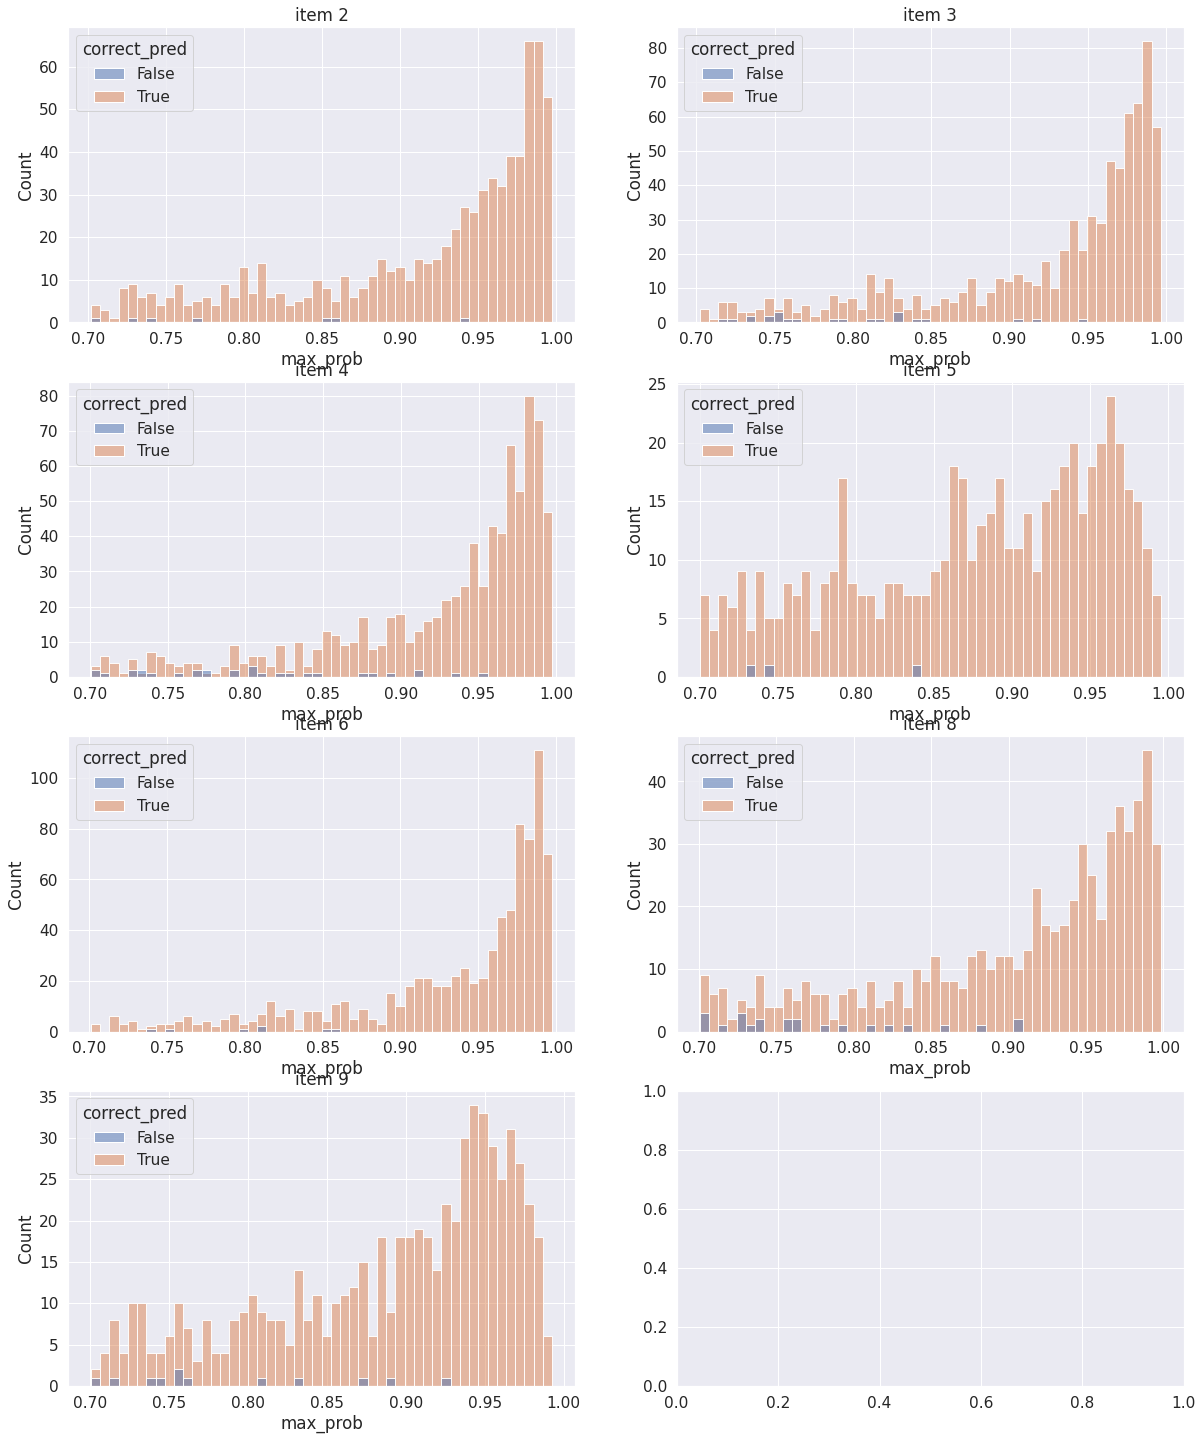

In [24]:
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(20,25))
count=0

for i in [2,3,4,5,6,8,9]:
    df=y_pred_only_use_labeled_data_df[(y_pred_only_use_labeled_data_df['predicted_label']==i) & (y_pred_only_use_labeled_data_df['max_prob']>0.7)]
    sns.histplot(data=df, x='max_prob', hue='correct_pred', ax=axs[(count)//2,count%2], bins=50).set(title='item '+str(i))
    sns.set(font_scale=1.4)
    #res.set_xticklabels(np.arange(start=0.090, stop=1.001, decimals=3), fontsize = 10)
    count+=1


## Improve SVM with unlabeled data - Semi-superised Learning

In [25]:
#self training
#add only labels model predict with high probability in each iterations
#create accuracy and pseudo labels list for later plotting
start_time = time.time()
test_accuracies = []
pseudo_labels = []
idx_w_labels=[]
idx_no_labels=[]
max_prob=[1,1,1,1,1,1,1,1,1,1]
min_prob=[0.95,0.95,0.95,0.95,0.95,0.925,0.95,0.96,0.95,0.95]

iterations=40

for i in range (iterations):
    #We've already train SVM once in previous section. So, train only after some pseudo labels added
    
    if i>=1:
       svc=SVC(C=10, gamma=0.014, probability=True).fit(X_train_w_label, y_train_w_label)
    #print counts of initial unlabeled data, high-probability predictions of unlabeled data, remaining unlabeled data
    print(f"Iteration {i}")
    print(f"Begin with {X_train_no_label.shape[0]} unlabeled data")
    
    y_pred_no_label_prob_full = svc.predict_proba(X_train_no_label)
    y_pred_no_label_prob = np.max( y_pred_no_label_prob_full , axis=1) 
    y_pred_no_label=np.argmax(y_pred_no_label_prob_full, axis=1)  %10

    #X_train_no_label=X_train_no_label[y_pred_no_label_prob<1]
    #y_train_no_label=y_train_no_label[y_pred_no_label_prob<1]
    #y_pred_no_label=y_pred_no_label[y_pred_no_label_prob<1]
    #y_pred_no_label_prob=y_pred_no_label_prob[y_pred_no_label_prob<1]

    print(f"After getting rid of Prob >0.995 unlabeled data, begin with {X_train_no_label.shape[0]} unlabeled data")

    #Remove a set of data from unlabeled data and put them to unlabeled data again 
    total_new_pseudo_labels=0
    for j in range(10):
            idx_w_label= (y_pred_no_label==j) & (y_pred_no_label_prob>min_prob[j])& (y_pred_no_label_prob<=max_prob[j])
            idx_no_label= np.where(idx_w_label==True, False, True)

    #Adding high-probablity unlabeled data to training, update no_labed data list
           
            X_train_w_label=np.concatenate( (X_train_w_label, X_train_no_label[idx_w_label]), axis=0)
            y_train_w_label=np.concatenate( (y_train_w_label, y_pred_no_label[idx_w_label]), axis=0)
          
            total_new_pseudo_labels+=X_train_no_label[idx_w_label].shape[0]  
            #print counts of new labels added to training data
            print(f"{X_train_no_label[idx_w_label].shape[0] } high-probability predictions of item {j} added to training data") 

            X_train_no_label=X_train_no_label[idx_no_label]   
            y_train_no_label=y_train_no_label[idx_no_label] 
            y_pred_no_label=y_pred_no_label[idx_no_label] 
            y_pred_no_label_prob=y_pred_no_label_prob[idx_no_label]
   
    #print total pseudo labels added in current iteration and unlabeled data remaining
    print(f"{total_new_pseudo_labels} high-probability predictions of all items added to training data") 
    print(f"{ X_train_no_label.shape[0]} unlabeled instances remaining")  
    
    #break if no labeled data has high probability
    if total_new_pseudo_labels==0:
        print("No non-labeled data left")
        break

    pseudo_labels.append(total_new_pseudo_labels)
    
    #predict testing set 
    y_pred_prob_full = svc.predict_proba(X_test)
    y_pred_prob = np.max( y_pred_prob_full , axis=1) 
    y_pred=np.argmax(y_pred_prob_full, axis=1)  %10
    #y_pred =svc.predict(X_test)
    test_accuracy=accuracy_score(y_test ,y_pred)
    
    #print and save accuracy score
    print(f"accuracy score: {test_accuracy*100}%\n")  
    test_accuracies.append(test_accuracy)

print("--- %s seconds ---" % (time.time() - start_time))

Iteration 0
Begin with 59400 unlabeled data
After getting rid of Prob >0.995 unlabeled data, begin with 59400 unlabeled data
2459 high-probability predictions of item 0 added to training data
2388 high-probability predictions of item 1 added to training data
1884 high-probability predictions of item 2 added to training data
2211 high-probability predictions of item 3 added to training data
2380 high-probability predictions of item 4 added to training data
1102 high-probability predictions of item 5 added to training data
3176 high-probability predictions of item 6 added to training data
1957 high-probability predictions of item 7 added to training data
1487 high-probability predictions of item 8 added to training data
790 high-probability predictions of item 9 added to training data
19834 high-probability predictions of all items added to training data
39566 unlabeled instances remaining
accuracy score: 91.60000000000001%

Iteration 1
Begin with 39566 unlabeled data
After getting rid o

In [26]:
test_accuracies

[0.916,
 0.919,
 0.9262,
 0.9336,
 0.9391,
 0.9417,
 0.9427,
 0.9438,
 0.9438,
 0.9448,
 0.9446,
 0.9452,
 0.9452,
 0.9456,
 0.9453,
 0.9457,
 0.9456,
 0.9458,
 0.9459,
 0.9455,
 0.9454,
 0.9456,
 0.9457,
 0.9458,
 0.9453]

Text(0.5, 0, '# Iterations')

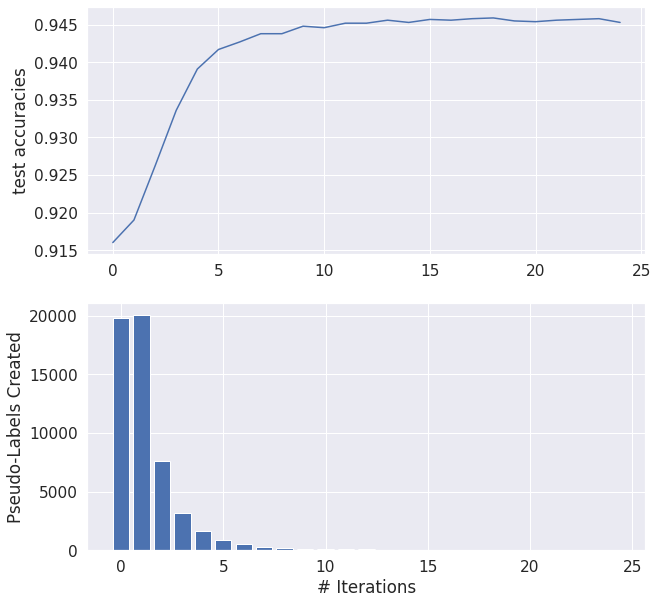

In [27]:
# Plot accuracy scores and number of pseudo-labels added for all iterations
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax1.plot(range(len(test_accuracies)), test_accuracies)
ax1.set_ylabel('test accuracies')
ax2.bar(x=range(len(test_accuracies)), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations')

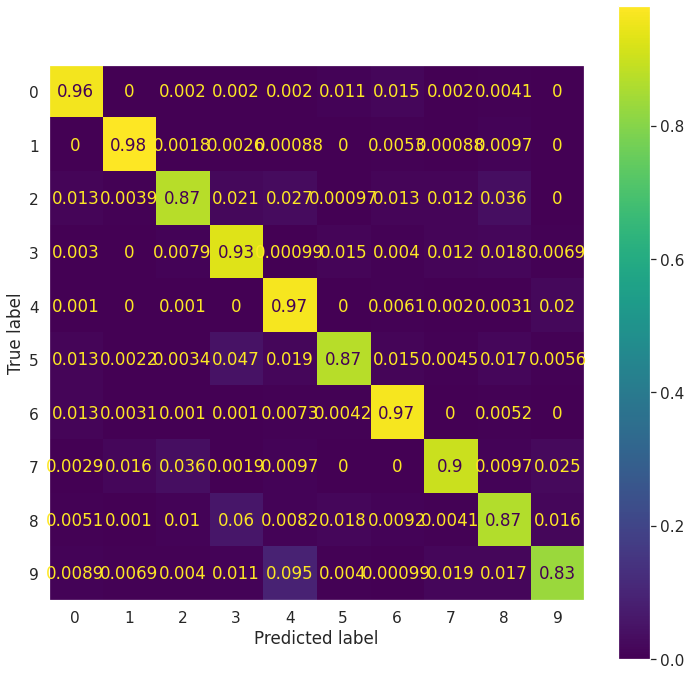

In [33]:
#Plot confusion Matrix
cm_only_use_labeled_data= confusion_matrix(y_test ,y_pred_only_use_labeled_data, normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_only_use_labeled_data, display_labels=model.classes_)
fig, ax=plt.subplots(figsize=(12,12))
ax.grid(False)
disp.plot( ax=ax)

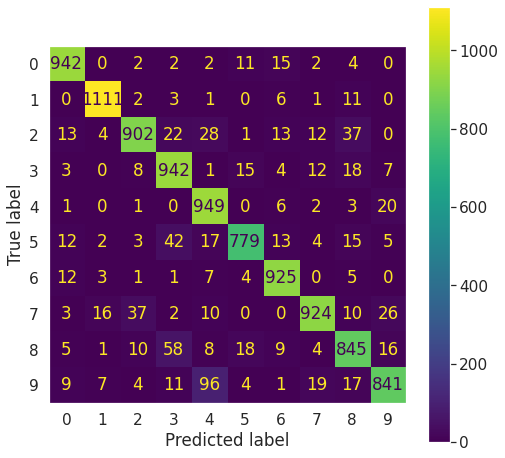

In [34]:
#Plot confusion Matrix
cm_only_use_labeled_data= confusion_matrix(y_test ,y_pred_only_use_labeled_data)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_only_use_labeled_data, display_labels=model.classes_)
fig, ax=plt.subplots(figsize=(8,8))
ax.grid(False)
disp.plot( ax=ax)

In [30]:
#Create data frame with probabilities, max probability, and predicated label for easy display
y_pred_concate= np.concatenate( (y_pred_prob_full, y_pred_prob.reshape(y_pred.shape[0],1),
                                                       y_pred.reshape(y_pred.shape[0],1), y_test.reshape(y_test.shape[0],1)), axis=1 )
y_pred_df = pd.DataFrame(y_pred_concate,columns=[0,1,2,3,4,5,6,7,8,9,'max_prob','predicted_label','actual_label'])

y_pred_df= y_pred_df.sort_values(by="max_prob", ascending=False)

#add indicator column to indicate correct prediction
y_pred_df['correct_pred'] = y_pred_df['actual_label'] == y_pred_df['predicted_label']

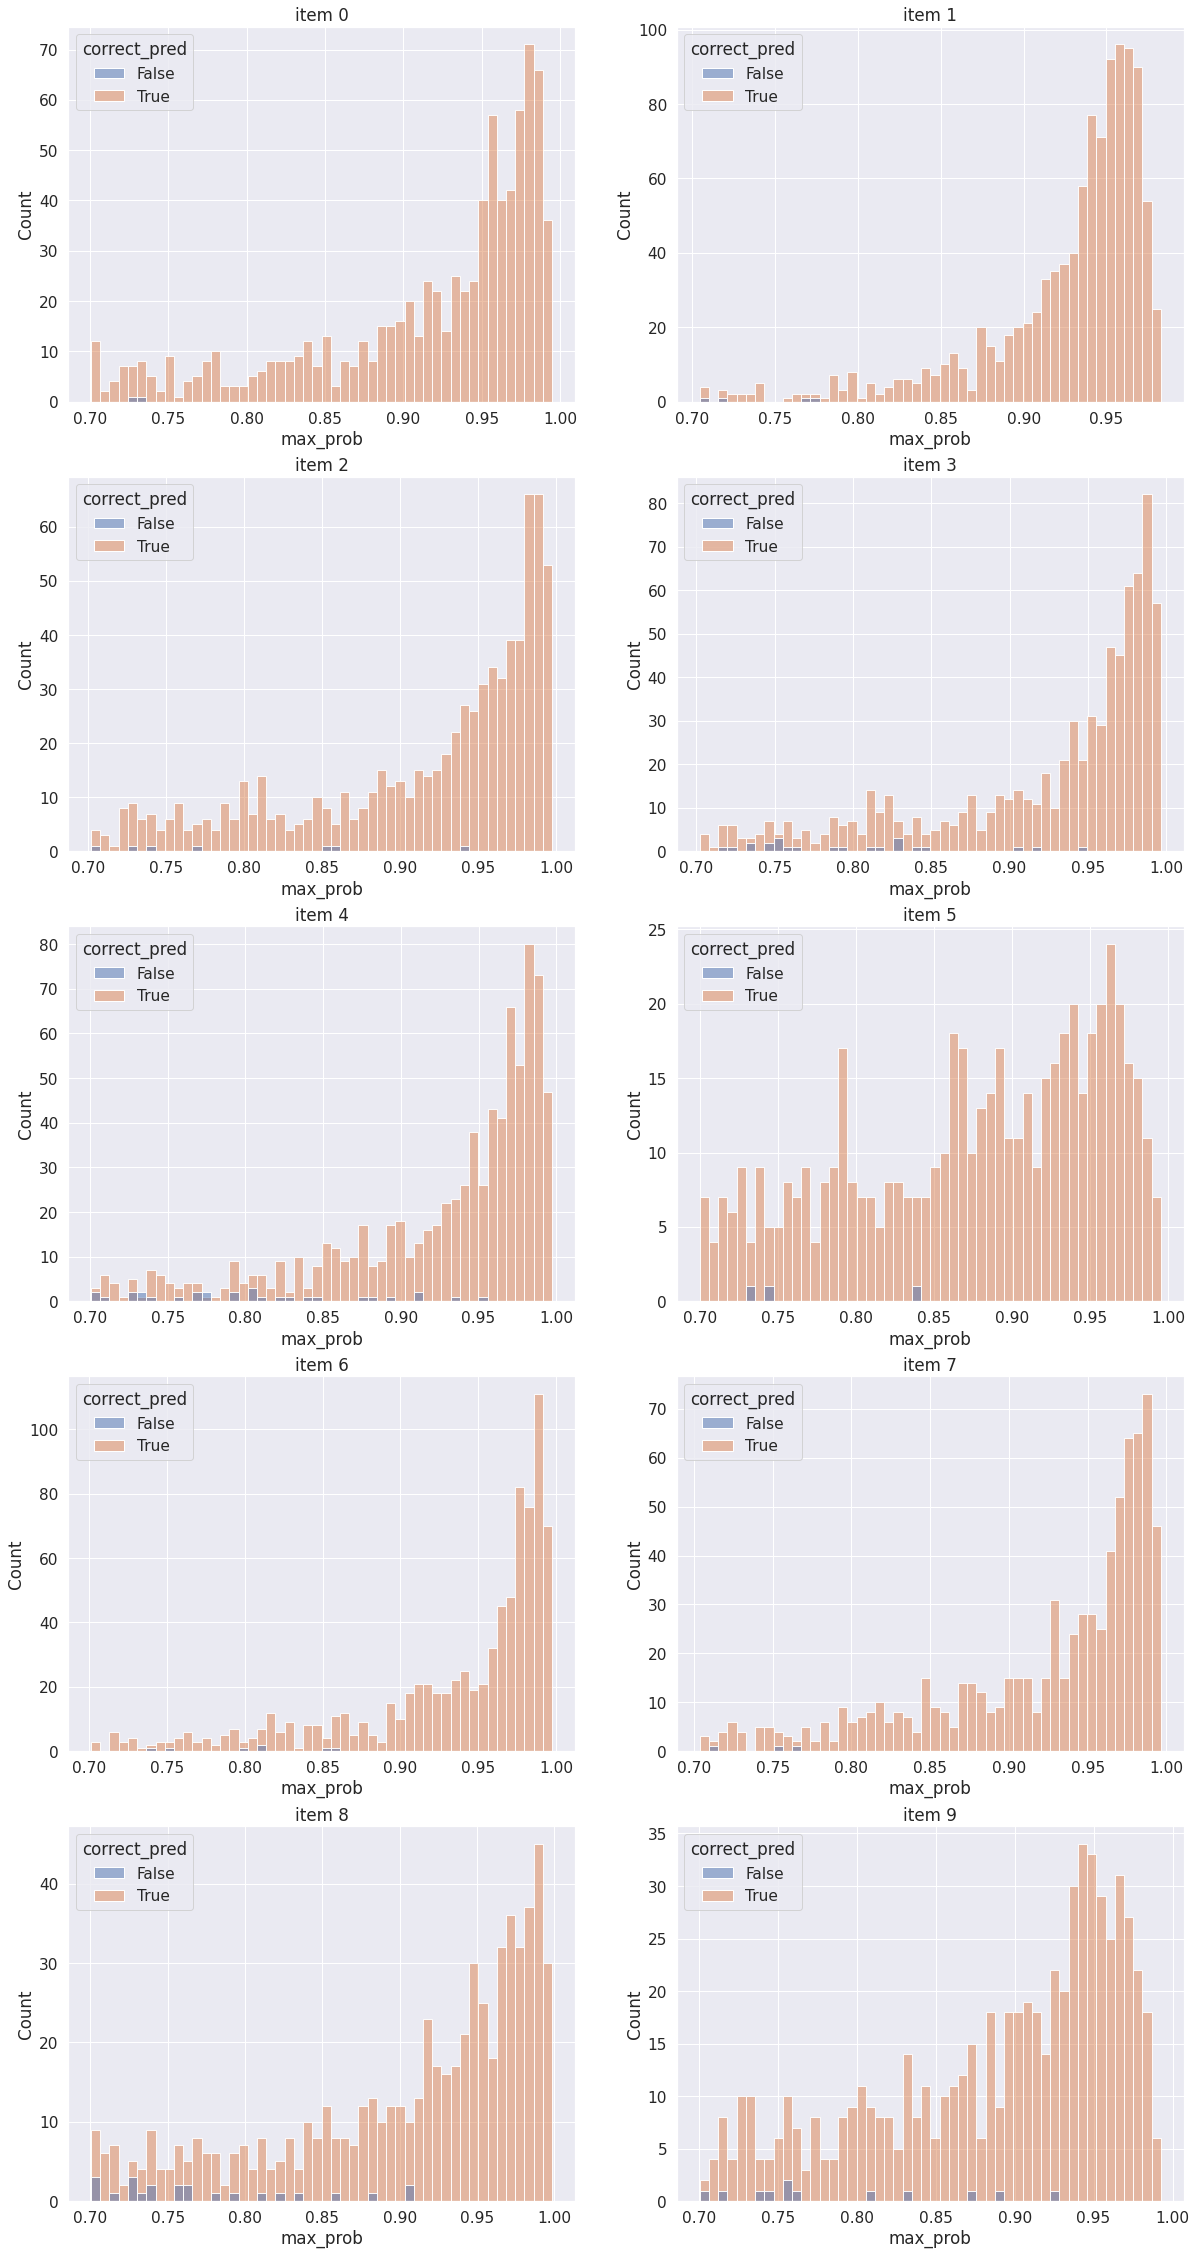

In [36]:
fig, axs = plt.subplots(nrows=5,ncols=2,figsize=(20,40))
count=0
for i in range(10):
    df=y_pred_only_use_labeled_data_df[(y_pred_only_use_labeled_data_df['predicted_label']==i) & (y_pred_only_use_labeled_data_df['max_prob']>0.7)& (y_pred_only_use_labeled_data_df['max_prob']<=0.999)]
    sns.histplot(data=df, x='max_prob', hue='correct_pred', ax=axs[(count)//2,(count)%2], bins=50).set(title='item '+str(i))
    sns.set(font_scale=1.4)
    count+=1
   